# Ripple NRTidal verification notebook

**Abstract:** Here, we check our implementation of NRTidalv2 in ripple. Currently, the high frequency regime does not match with the implementation in LAL. After checking the code, it is not immediately clear where the bug is coming from, but some reasons that likely (either fully or partially) influence this error:
- The Planck taper has not been added yet, which removes the amplitude for high frequency
- The spin-spin contribution is currently manually set to zero, since this gives completely wrong results.

The final plot, showing the difference between the LAL and ripple implementation, shows also an increasing error in amplitude with increasing frequency. I think the above two reasons are unrelated to this, so it may be that there is still (besides the above two issues) another bug in the code, but I am not sure about this. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

%load_ext autoreload
%autoreload 2
from ripple.waveforms import X_NRTidalv2

# To get plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

In [2]:
m1 = 2 # masses
m2 = 2

chi1 = 0.7 # spins
chi2 = 0.7

lambda1 = 5000 # tidal deformabilities
lambda2 = 5000

distance = 440.

Get the frequency grid:

In [3]:
# Frequency grid
T = 16
f_l = 20.0
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
# df = freqs[1] - freqs[0]
df = 0.01
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [4]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = 0.0
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs_ripple, theta_ripple, f_ref)

0.0
[1.74110113e+00 2.50000000e-01 7.00000000e-01 7.00000000e-01
 4.40000000e+02 0.00000000e+00 0.00000000e+00]


## LAL

Check the LAL code (and also how to compute the mismatch between your waveform and LAL) in [this tutorial](https://github.com/tedwards2412/ripple/blob/main/test/check_waveform_match.py).

In [5]:
import lalsimulation as lalsim
import lal

from ripple import get_eff_pads, get_match_arr

In [6]:
IMRphenom = "IMRPhenomD_NRTidalv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    lambda1,
    lambda2,
    df,
    f_l,
    f_u,
    f_ref,
    None,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

# Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

# theta_ripple = np.array(
#     [Mc, eta, theta[2], theta[3], dist_mpc, tc, phic, inclination]
# )
# hp_ripple = waveform(theta_ripple)
pad_low, pad_high = get_eff_pads(fs)
PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

## Comparison

In [7]:
# One frequency variable, just f
f = fs_ripple

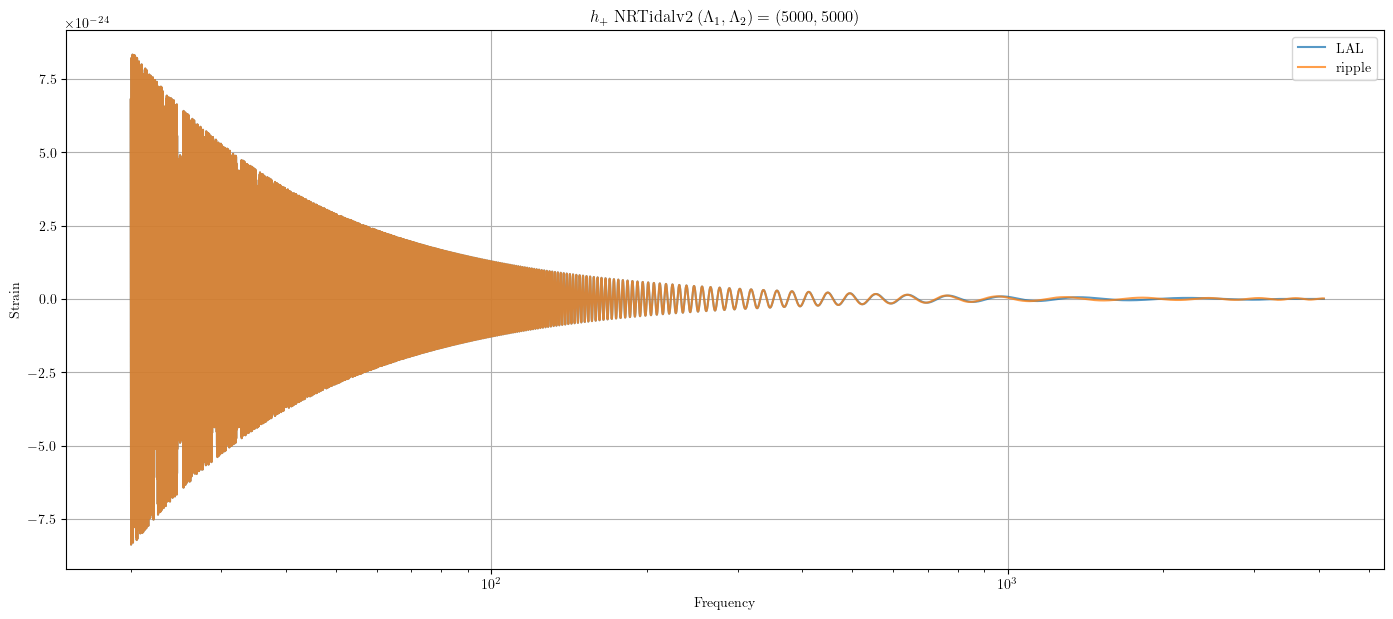

In [8]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

**Discussion:** Visually, the match is really great, except for the higher frequency regime. 

Get the merger frequency for the Planck taper:

In [9]:
merger_params = jnp.array([m1, m2, chi1, chi2, lambda1, lambda2])
f_merger = X_NRTidalv2._get_f_merger(merger_params)
f_merger = float(f_merger)
print("Merger params (m1, m2, chi1, chi2, lambda1, lambda2): ", merger_params)
print("Frequency merger: ", f_merger)

Merger params (m1, m2, chi1, chi2, lambda1, lambda2):  [2.e+00 2.e+00 7.e-01 7.e-01 5.e+03 5.e+03]
Frequency merger:  4774.99091072249


Check the amplitude and the phase separately

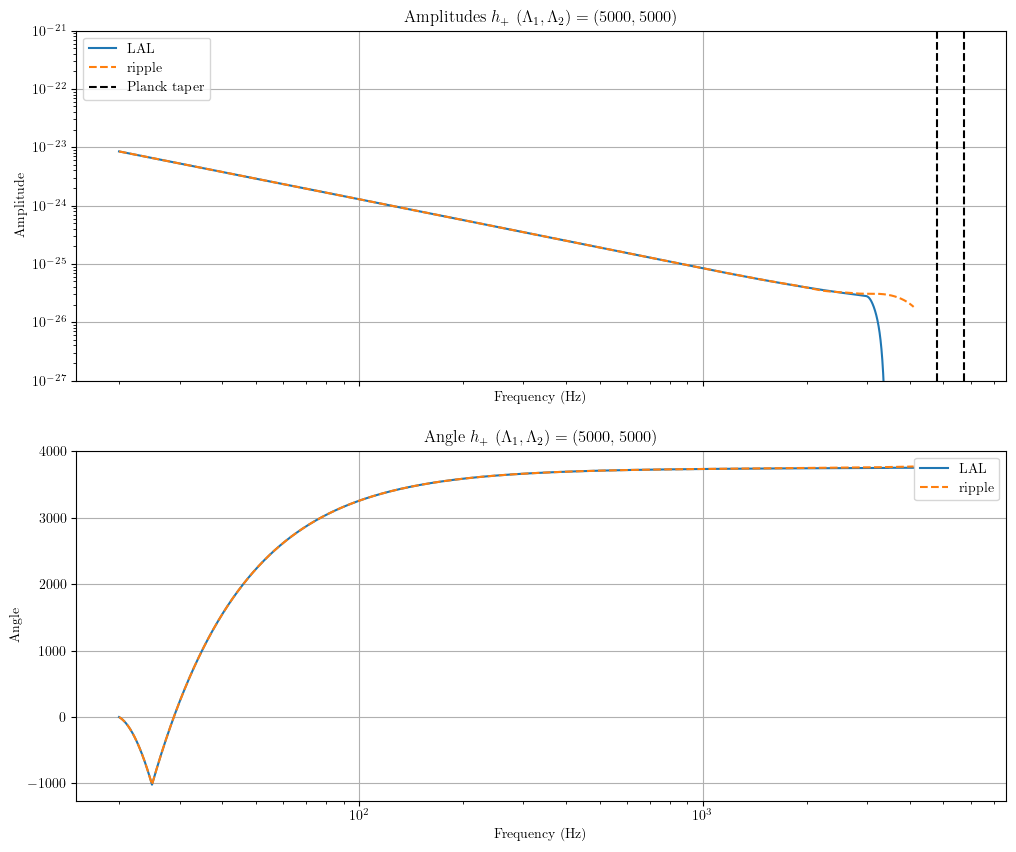

In [10]:
A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

**Discussion:** Again, we see that at high frequencies, there is a mismatch. For the amplitude, this could be solved by the Planck taper. However, the tapering window that I find (see dashed black lines) will not fix this issue. For the phase/angle: this is likely solved by adding the contribution from the spin-spin interaction, which is currently giving wrong results (one has to double check the implementation in the source code).

**Note:** There is a small difference in step size of the frequency grid between the one employed by LAL and the one used by ripple (not sure why). This is, however, only a small change in the final frequency, so negligible. Also checked with doing an interpolation of frequency grids: this does not affect the errors reported below.

In [11]:
df_ripple = fs_ripple[1] - fs_ripple[0]
df_lal = freqs_lal[1] - freqs_lal[0]

print(df_ripple)
print(df_lal)

print(fs_ripple[-1])
print(freqs_lal[mask_lal][-1])
print(abs(freqs_lal[mask_lal][-1] - fs_ripple[-1]))

0.010000000000001563
0.01
4095.9900000006373
4095.9900000000002
6.371010385919362e-10


In [12]:
correct_freqs = True # correct frequency grid by interpolation
if correct_freqs:
    A_lalsuite = jnp.interp(f, freqs_lal[mask_lal], A_lalsuite)
    angle_lalsuite = jnp.interp(f, freqs_lal[mask_lal], angle_lalsuite)

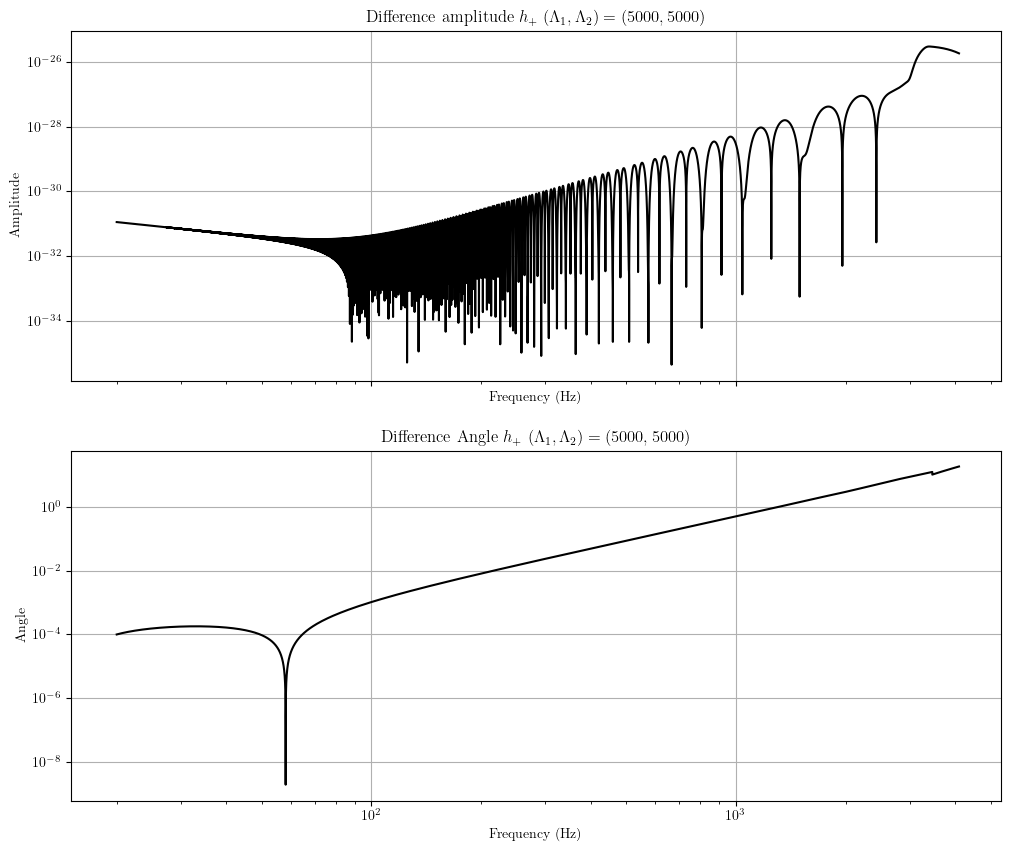

In [13]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(f, abs(A_lalsuite - A_ripple), "-", color = 'black')

# Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Difference amplitude $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"Difference {} $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.yscale('log')
plt.show()

**Discussion:** Same remarks as above. For the angle, the spin-spin contributions could solve the increasing error in the second plot. For the amplitude: I am a bit surprised that the error in amplitude seems to be increasing with increasing frequency and I am not sure what is causing this. This will not be fixed by the Planck taper. Is there another bug in the implementation? 

# Waveform check

This is implemented as a Python script in the ripple package and work in progress. Current log10 mismatch values are around -3, whereas the ripple paper achieved around -12 for their BBH waveforms. So, have to solve the above issues.